# LSTM on Equity Forecasting

Based on https://github.com/ghst659/sml00/blob/main/forecast/lstm_rnn_airline.ipynb

In [45]:
%matplotlib inline

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sklearn

import iolib

## Data Import

Import the raw data into a pandas `DataFrame`.

In [47]:
_DATA_FILE = "data/nasdaq/GOOG.csv"
goog = iolib.read_nasdaq(_DATA_FILE).sort_values(by="Date")
# sort the values
goog.info()
goog.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2517 entries, 2516 to 0
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2517 non-null   datetime64[ns]
 1   Close/Last  2517 non-null   float64       
 2   Volume      2517 non-null   int64         
 3   Open        2517 non-null   float64       
 4   High        2517 non-null   float64       
 5   Low         2517 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 137.6 KB


,Date,Close/Last,Volume,Open,High,Low
2516,2014-12-15,25.6900,56126000,26.1370,26.1550,25.6635
2515,2014-12-16,24.7695,78929000,25.5780,25.6525,24.4500
2514,2014-12-17,25.2445,57472000,24.8500,25.3500,24.8405
2513,2014-12-18,25.5550,58218400,25.6475,25.6935,25.2350
2512,2014-12-19,25.8175,72239600,25.5755,25.8860,25.3455


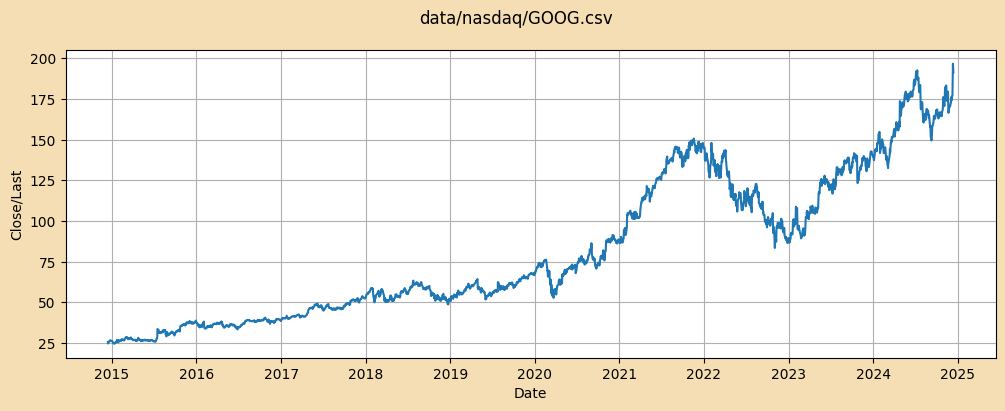

In [48]:
# Plot the raw data.
def plot_values(tbl: pd.DataFrame, x_name: str, y_name: str, title: str) -> None:
    fig = plt.figure(figsize=(12,4), facecolor="wheat")
    fig.suptitle(title)
    chart_area = fig.add_subplot()
    chart_area.grid(visible=True)
    chart_area.set_xlabel(x_name)
    chart_area.set_ylabel(y_name)
    curve = chart_area.plot(tbl[x_name], tbl[y_name])

plot_values(goog, "Date", "Close/Last", _DATA_FILE)

## Data Conversion for LSTM

The LSTM will require just a sequence of normalised values.

,Date,Close/Last,Volume,Open,High,Low,P
2516,2014-12-15,25.6900,56126000,26.1370,26.1550,25.6635,0.006174
2515,2014-12-16,24.7695,78929000,25.5780,25.6525,24.4500,0.000825
2514,2014-12-17,25.2445,57472000,24.8500,25.3500,24.8405,0.003585
2513,2014-12-18,25.5550,58218400,25.6475,25.6935,25.2350,0.005390
2512,2014-12-19,25.8175,72239600,25.5755,25.8860,25.3455,0.006915


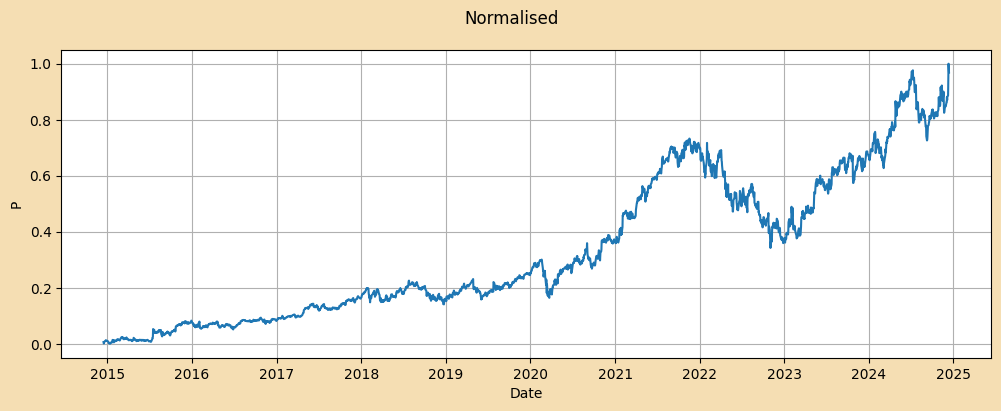

In [49]:
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
goog["P"] = scaler.fit_transform(goog["Close/Last"].to_frame())

plot_values(goog, "Date", "P", "Normalised")
goog.head()  # Note the additional "P" column of normalised Close/Last values.

In [50]:
_TRAIN_FRAC = 0.67
train_count = int(len(goog) * _TRAIN_FRAC)
test_count = len(goog) - train_count
full_seq: np.ndarray = goog["P"].to_frame().values
train_seq = full_seq[:train_count]
test_seq = full_seq[train_count:]
print(train_seq.shape, test_seq.shape)
print(train_seq)

(1686, 1) (831, 1)
[[0.00617436]
 [0.00082519]
 [0.00358549]
 ...
 [0.67683814]
 [0.68438685]
 [0.68759171]]


In [51]:
def create_dataset(sequence: pd.DataFrame, look_back: int = 1) -> tuple[np.ndarray, np.ndarray]:
    """Convert SEQUENCE of values into a dataset matrix with a given LOOK_BACK"""
    data_x: list(np.ndarray) = []
    data_y: list(float) = []
    for i in range(len(sequence)-look_back-1):  # 144 - 1 + 1 = 0..143 inclusive.
        a = sequence[i:(i+look_back), 0]  # look_back rows starting from i, column 0
        data_x.append(a)  # appends an ndarray of length look_back
        data_y.append(sequence[i + look_back, 0])  # appends a float value.
    return np.array(data_x), np.array(data_y)

In [52]:
_LOOK_BACK = 1
train_x, train_y = create_dataset(train_seq, _LOOK_BACK)
test_x, test_y = create_dataset(test_seq, _LOOK_BACK)

In [53]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1684, 1, 1) (829, 1, 1) (1684,) (829,)


## Model Definition

In [54]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(1, _LOOK_BACK)))
model.add(tf.keras.layers.LSTM(4))
model.add(tf.keras.layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

Train the model for 100 epochs, with a batch size of 1.

In [55]:
model.fit(train_x, train_y, epochs=25, batch_size=1, verbose=1)

Epoch 1/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0137
Epoch 2/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.6462e-05
Epoch 3/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.4084e-05
Epoch 4/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.8631e-05
Epoch 5/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.3733e-05
Epoch 6/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.4036e-05
Epoch 7/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.6970e-05
Epoch 8/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.9744e-05
Epoch 9/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.1647e-05
Epoch 10/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.5114e-05
Epoch 11/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 5.0176e-05
Epoch 12/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 4.1406e-05 
Epoch 13/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4.1196e-05
Epoch 14/25
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/

## Make Predictions

In [56]:
# Get raw predictions in normalised form.
train_raw_predict = model.predict(train_x)
test_raw_predict = model.predict(test_x)

# Invert (de-normalise) the predictions.
train_denorm_predict = scaler.inverse_transform(train_raw_predict)
train_denorm_y = scaler.inverse_transform([train_y])
test_denorm_predict = scaler.inverse_transform(test_raw_predict)
test_denorm_y = scaler.inverse_transform([test_y])

# Calculate RMS error
train_score = np.sqrt(sklearn.metrics.mean_squared_error(train_denorm_y[0], train_denorm_predict[:, 0]))
print(f"training score: {train_score:.2f} RMSE")
test_score = np.sqrt(sklearn.metrics.mean_squared_error(test_denorm_y[0], test_denorm_predict[:, 0]))
print(f"test score: {test_score:.2f} RMSE")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
training score: 1.03 RMSE
test score: 3.30 RMSE


Shift data sets to plot on the same X timeline.

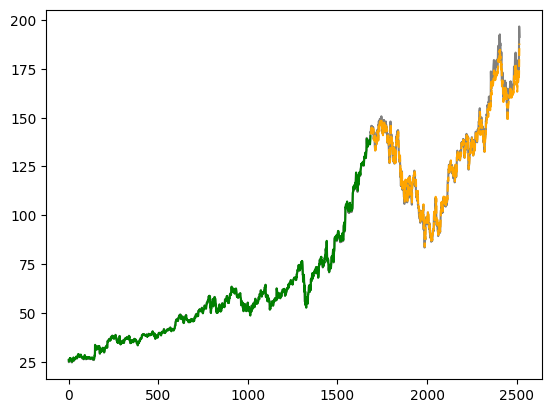

In [57]:
train_plot = np.empty_like(full_seq)
train_plot[:, :] = np.nan
train_plot[_LOOK_BACK:len(train_denorm_predict) + _LOOK_BACK, :] = train_denorm_predict

test_plot = np.empty_like(full_seq)
test_plot[:, :] = np.nan
test_plot[len(train_denorm_predict) + (_LOOK_BACK * 2) + 1: len(full_seq) - 1, :] = test_denorm_predict

plt.plot(scaler.inverse_transform(full_seq), linestyle="solid", color="grey")
plt.plot(train_plot, linestyle="solid", color="green")
plt.plot(test_plot, linestyle="dashed", color="orange")
plt.show()